# Self-supervised Learning for Litholoy Analysis
In this notebook, we will train a self-supervised learning model (more specifically SWAV) on cropped tiles from the 14 drill holes. 

In [47]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.data.all import *
import numpy as np
import matplotlib.pyplot as plt
from self_supervised.augmentations import *
from self_supervised.layers import *
import rasterio
import os
import torch

/home/ubuntu/miniconda3/envs/fastai/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


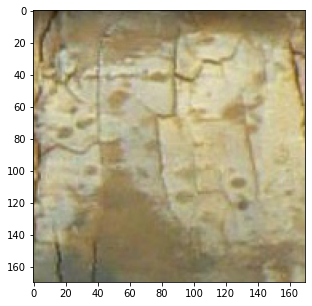

In [48]:
img_dir = f"../data/processed/coherent_tiles/" # location of the tif images
num_channels = 3 # number of channels in each tile
size=112 # image size
# store the name of all image files in img_dir
img_paths = [os.path.join(img_dir,file) for file in os.listdir(img_dir) if file.endswith(('.jpg'))]
img_paths.sort()
idx = 0

# read one tile in and plot each 3 channels of the tile as one RGB image
file = rasterio.open(str(img_paths[0])) # img is of type numpy.ndarray
r = file.read(1)
g = file.read(2)
b = file.read(3)
img = np.stack([r,g,b], axis=2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)
plt.show();

In [49]:
# a read function for the tif images 
def open_img(pth, chnls=None, cls=torch.Tensor):
    file = rasterio.open(pth)
    r, g, b, = file.read(1), file.read(2), file.read(3)
    img = np.stack([r,g,b], axis=2)
    im = torch.from_numpy(img).type(torch.float32)
    if chnls is not None: 
        im = im[...,chnls]
    return cls(im)

# a custom class to store the tile images and pass them to the DataBlock object
class MCTensorImage(TensorImage):
    
    def __init__(self, x, chnls=None, chnls_first=False):
        self.chnls = chnls

    @classmethod
    def create(cls, data:(str,ndarray), chnls=None, chnls_first=False):
        
        if  isinstance(data, str):
            if str(data).endswith('jpg'): im = open_img(pth=data, chnls=chnls, cls=torch.Tensor)

        elif isinstance(data, ndarray): 
            im = torch.from_numpy(data)
        else:
            im = data

        # normalize pixel values to the range [0,1]
        im = torch.div(im, 255)
        
        return cls(im, chnls_first=chnls_first)

    # a function to show different channels of the tiles
    def show(self, chnls=[0,1,2], bright=1., ctx=None, title=None):
        
        if img.ndim > 2:
            if chnls is not None:
                visu_img = self[..., chnls]
        else:
            visu_img = self
        
        visu_img *= bright
        visu_img = np.where(visu_img > 1, 1, visu_img)
        visu_img = np.where(visu_img < 0, 0, visu_img)
        
        if ctx is None:
            plt.imshow(visu_img) 
            if title is not None:
                plt.title.set_text(title)
                plt.axis('off')
        else:
            ctx.imshow(visu_img)
            if title is not None:
                ctx.title.set_text(title)
                ctx.axis('off')
        
        return ctx
    
    def __repr__(self):
        
        return (f'MCTensorImage: {self.shape}')

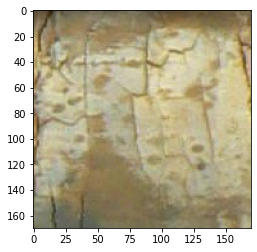

In [50]:
# use the custom class to read one tile image
img = MCTensorImage.create(img_paths[idx])

# show different channels of the tile image
fig, ax = plt.subplots(figsize=(12, 4))
img.show(bright=1., ctx=ax);

In [51]:
import albumentations as A 

# a custom transformation function for input images of type MCTensorImage 
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: MCTensorImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        aug_img *= 255
        aug_img = aug_img.astype('uint8')
        aug_img = PILImage.create(aug_img)
        return aug_img

        
# transformation functions for the training dataset
def get_train_aug(): return A.Compose([
                      A.VerticalFlip(),
                      A.Rotate(limit=90),
                      A.ShiftScaleRotate(p=.9),
                      A.HorizontalFlip(),
                      A.Resize(size, size)
                      #A.CoarseDropout(max_holes=5, max_height=5, max_width=5, fill_value=0)
        ])

# transformation functions for the validation dataset
def get_valid_aug(): return A.Compose([
                      A.VerticalFlip(),
                      A.Rotate(limit=90),
                      A.ShiftScaleRotate(p=.9),
                      A.HorizontalFlip(),
                      A.Resize(size,size)
                      #A.CoarseDropout(max_holes=5, max_height=5, max_width=5, fill_value=0)
        ])

In [52]:
def get_y(x):
    return 1

# this function creates a DataLoader for the tile images
def create_dls(df, size=224, col_splitter=False, bs=128):
    
    if col_splitter:
        splitter = ColSplitter("is_valid")
    else:
        splitter = RandomSplitter(valid_pct=0.1, seed=36)
    
    
    item_tfms =  [AlbumentationsTransform(get_train_aug(), get_valid_aug())]
    batch_tfms = [IntToFloatTensor]
    
  
    # create a datablock    
    rocks = DataBlock(
                blocks = (TransformBlock(type_tfms=partial(MCTensorImage.create, chnls_first=False)), CategoryBlock),
                get_x = ColReader('path'),
                splitter = splitter,
                get_y = partial(get_y),
                item_tfms = item_tfms,
                batch_tfms = batch_tfms
            )

    # generate the dataloader
    dls = rocks.dataloaders(df,bs=bs, shuffle=False, drop_last=True)
    return dls


In [53]:
import pandas as pd
      
bs=128
seed = 123
set_seed(seed) # set random seed
project_name = 'litho' 
encoder_name = "resnet50" # define encoder architecture eg. xresnet34
algorithm = "SWAV"
hidden_size = 256
 # size of the layer before feature layer

projection_size = 256 # feature size
lr,wd,epochs=1e-4,1e-3,300 # initializing hyperparameter values
model_name = f"{project_name}_{encoder_name}_{algorithm}_{hidden_size}hs_{projection_size}ps"
model_name += f"_{bs}bs_{lr}lr_{epochs}epochs_{seed}seed"
model_dir = '../outputs' # directory where the trained model will be saved

model_name # name of the stored model files

# read the csv file containing location of the tile images
csv_file_path = f"../data/processed2/all_tiles.csv"
df_train = pd.read_csv(csv_file_path)
df_train['label'] = 1
df_train.head()

,filename,path,label
0,MSDP12_91+92_284.79_285.79-box-0-row-3_15,../data/processed2/coherent_tiles/MSDP12_91+92_284.79_285.79-box-0-row-3_15.jpg,1
1,MSDP14_53+54_192.28_193.17-box-1-row-1_17,../data/processed2/coherent_tiles/MSDP14_53+54_192.28_193.17-box-1-row-1_17.jpg,1
2,MSDP07_23+24_58.66_59.5-box-1-row-2_1,../data/processed2/coherent_tiles/MSDP07_23+24_58.66_59.5-box-1-row-2_1.jpg,1
3,MSDP07_148+149_538.6_539.6-box-1-row-4_16,../data/processed2/coherent_tiles/MSDP07_148+149_538.6_539.6-box-1-row-4_16.jpg,1
4,MSDP10_69+70_246.91_247.72-box-0-row-4_4,../data/processed2/coherent_tiles/MSDP10_69+70_246.91_247.72-box-0-row-4_4.jpg,1


/home/ubuntu/miniconda3/envs/fastai/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


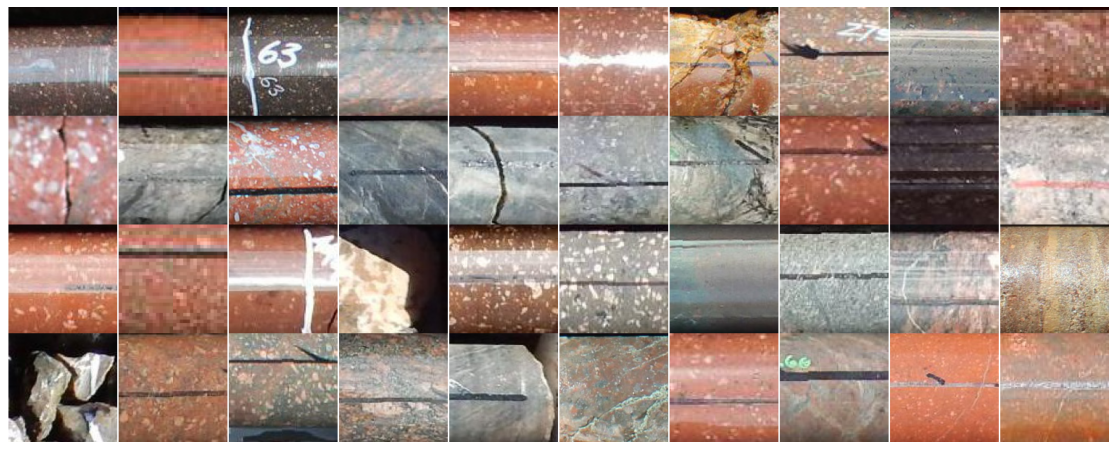

In [54]:
import cv2

def show_grid_imgs(fnames, size=150, fig_base_size=2, n_cols=10, save_path=None):

    # get number of rows 
    n_rows = len(fnames)//n_cols
    if len(fnames) > 0:
        imgs = [] # list row of squares
        for i in range(n_rows + 1):
            if i*n_cols == len(fnames):
                break
            fns = fnames[i*n_cols:(i+1)*n_cols]
            file = rasterio.open(fns[0])
            r, g, b, = file.read(1), file.read(2), file.read(3)
            img = np.stack([r,g,b], axis=2)
            img = cv2.resize(img,(size,size), interpolation=cv2.INTER_AREA)
            size = img.shape[0]
            if len(fns) > n_cols:
                list_imgs = []
                for fn in fns[:n_cols]:
                    file = rasterio.open(fn)
                    r, g, b, = file.read(1), file.read(2), file.read(3)
                    img = np.stack([r,g,b], axis=2)
                    list_imgs.append(np.hstack([np.full(shape=(size,2,3),fill_value=255,dtype=int),
                    np.array(cv2.resize(img,(size,size), interpolation=cv2.INTER_AREA))]))
            else:
                list_imgs = []
                for fn in fns[:]:
                    file = rasterio.open(fn)
                    r, g, b, = file.read(1), file.read(2), file.read(3)
                    img = np.stack([r,g,b], axis=2)
                    list_imgs.append(np.hstack([np.full(shape=(size,2,3),fill_value=255,dtype=int),
                    np.array(cv2.resize(img,(size,size), interpolation=cv2.INTER_AREA))]))
                list_imgs += [np.hstack([np.full(shape=(size,2,3),fill_value=255,dtype=int),
                np.full(shape=(size,size,3),fill_value=255,dtype=int)]) for i in range(n_cols-len(fns))]
            img = np.hstack(list_imgs)
            imgs += [img]
        if len(imgs) != 0 :
            img = PILImage.create(np.array(np.vstack(imgs),dtype=np.uint8))
            if save_path != None: img.save(save_path)
            else: img.show(figsize=(fig_base_size*n_cols,fig_base_size*n_rows))

# define dataloaders
dls = create_dls(df_train, col_splitter=False,bs=bs)
show_grid_imgs(dls[0].items.path.values[:40], n_cols=10);

AdaptiveConcatPool2d(
  (ap): AdaptiveAvgPool2d(output_size=1)
  (mp): AdaptiveMaxPool2d(output_size=1)
)


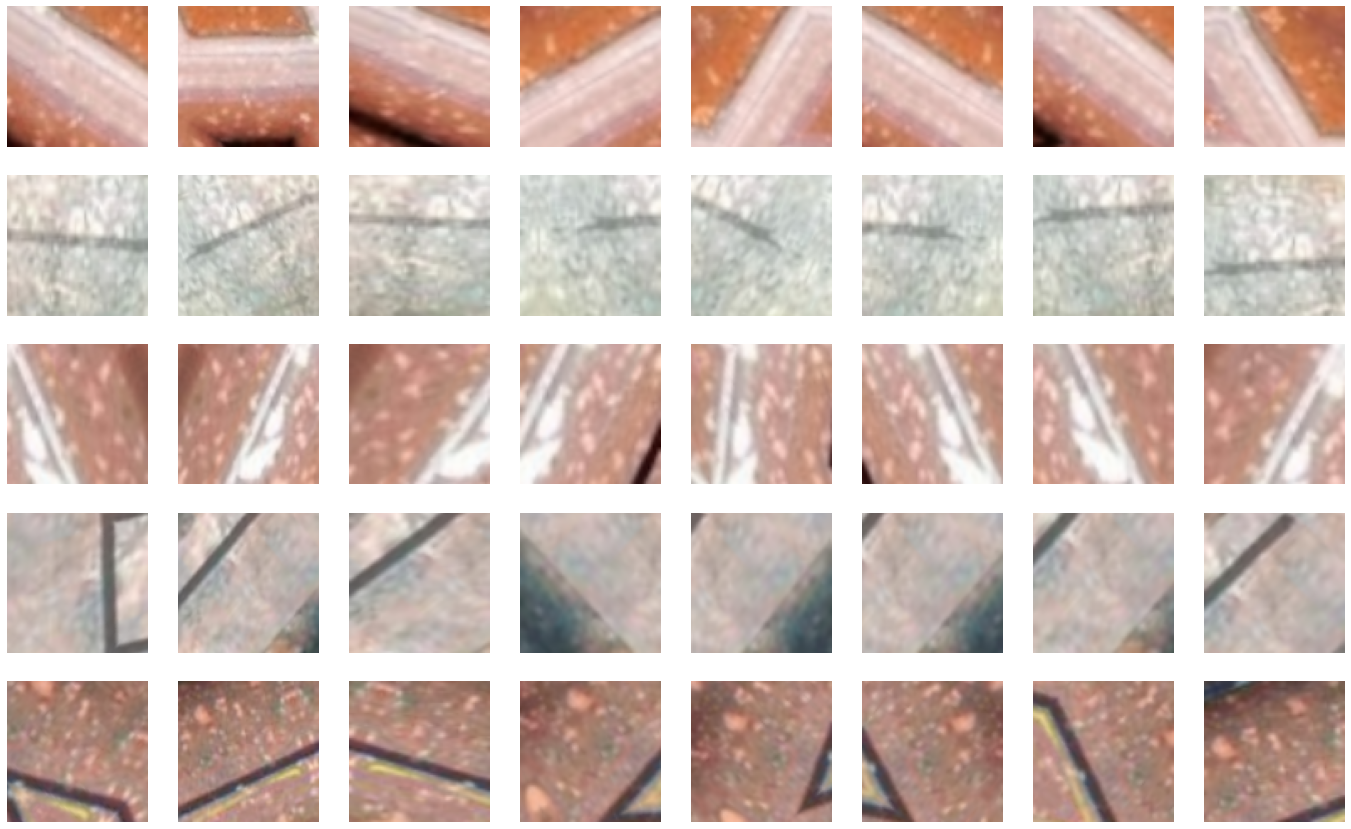

In [55]:
from self_supervised.vision.swav import *

# define the encoder architecture
encoder = create_encoder(encoder_name, n_in=3, pretrained=True) # a fastai encoder
#encoder = create_encoder("tf_efficientnet_b4_ns", n_in=3, pretrained=False) # a timm encoder

# create an instance of SWAV model with the defined encoder
model = create_swav_model(encoder, hidden_size=hidden_size, projection_size=projection_size)

# define the transformations for the SWAV model
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[size,int(3/4*size)], 
                                       min_scales=[0.25,0.2],
                                       max_scales=[1.0,0.35],
                                       rotate=True, rotate_deg=45, jitter=False, bw=False, blur=False) 

cbs=[SWAV(aug_pipelines=aug_pipelines, crop_assgn_ids=[0,1], K=bs*2**6, queue_start_pct=0.5, temp=0.1)]

# generate a learner object with the defined dataloader, SWAV model and augmentation pipeline
learn = Learner(dls, model, cbs=cbs, model_dir=model_dir)

print(learn.model.encoder[8])

# show a batch of augmented tiles
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show(n=5);

In [56]:
# train the model
learn.to_fp16()
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=20), 
SaveModelCallback(monitor='valid_loss', with_opt=True, fname=f"../outputs/{model_name}_best"),
SaveModelCallback(every_epoch=100, with_opt=True, fname=f"../outputs/{model_name}_epoch")]);

Better model found at epoch 0 with valid_loss value: 5.710651874542236.
Better model found at epoch 1 with valid_loss value: 5.276821613311768.
Better model found at epoch 2 with valid_loss value: 5.104228496551514.
Better model found at epoch 3 with valid_loss value: 4.986980438232422.
Better model found at epoch 4 with valid_loss value: 4.964828968048096.
Better model found at epoch 5 with valid_loss value: 4.927339553833008.
Better model found at epoch 6 with valid_loss value: 4.902518272399902.
Better model found at epoch 7 with valid_loss value: 4.862760543823242.
Better model found at epoch 8 with valid_loss value: 4.856520175933838.
Better model found at epoch 9 with valid_loss value: 4.852206707000732.
Better model found at epoch 12 with valid_loss value: 4.842748641967773.
Better model found at epoch 13 with valid_loss value: 4.8412089347839355.
Better model found at epoch 15 with valid_loss value: 4.840054035186768.
Better model found at epoch 16 with valid_loss value: 4.8358

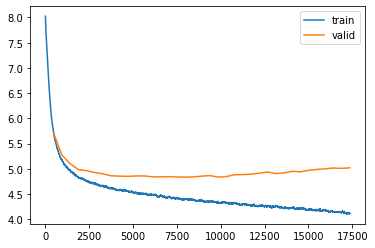

In [57]:
# save the model
learn.save(f"../outputs/{model_name}")
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{model_name}_encoder.pth')
learn.export(f"../outputs/{model_name}.pkl")
torch.save(dls, f"../outputs/dls.pkl")
fig= plt.figure()
learn.recorder.plot_loss()
fig.savefig(f"../outputs/loss_{seed}seed.png", facecolor='white', transparent=False)